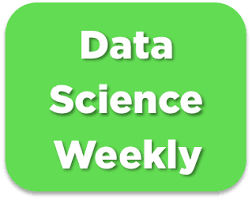

# Challenge : predict conversions 🏆🏆

The goal of this challenge is to get the best f1-score ! May the force be with you 🧨🧨  

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC

!pip install xgboost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe"
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
# Count rows
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset


##### Searching for missing values: no missing values!

In [4]:
# Visualize missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


##### Short description of the data

In [5]:
# Describe dataset
data.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


##### Removing outliers to age. Also and applying a log scale in order to reduce it's range.

<AxesSubplot:xlabel='age', ylabel='Count'>

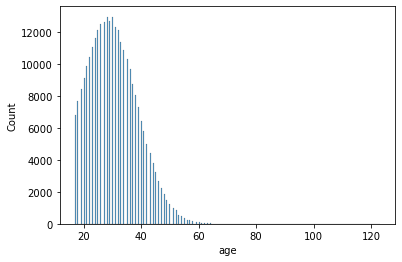

In [6]:
# Visualize people age
sns.histplot(data.age)

In [7]:
# Visualize people more than 80 years old
data[data["age"] > 80]

,country,age,new_user,source,total_pages_visited,converted
11331,UK,111,0,Ads,10,1
233196,Germany,123,0,Seo,15,1


<AxesSubplot:xlabel='age', ylabel='Count'>

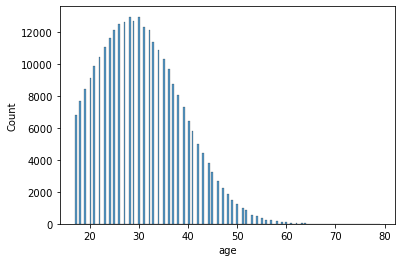

In [8]:
# Only two: remove people more than 80 years old
data = data[data["age"] <= 80]
sns.histplot(data.age)

<AxesSubplot:xlabel='age_log', ylabel='Count'>

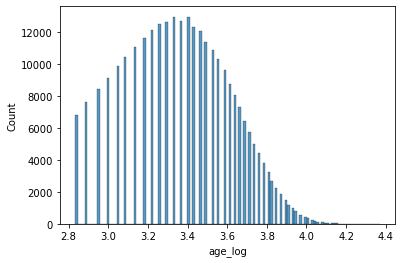

In [9]:
# Create a new column with age log
data["age_log"] = data["age"].apply(lambda x: math.log(x))

# Visualize age log
sns.histplot(data.age_log)

##### In the correlation matrix we see a notable correlation between total_page_visited and our target.

<AxesSubplot:>

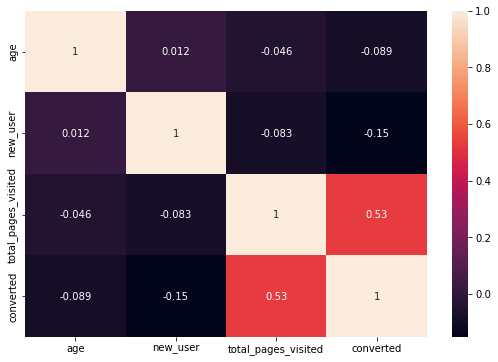

In [10]:
# Create correlation matrix between all columns
corr = data[["age", "new_user","total_pages_visited","converted"]].corr()

# Plot correlation matrix
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, ax=ax)

# Make the model

## Choose variables to use in the model, and create train and test sets
Here we create different variables to feed our different models.

In [11]:
target_variable = 'converted'

# data 0: simple column
features_list_0 = ['total_pages_visited']
numeric_indices_0 = [0]
categorical_indices_0 = []

# data 1: all column
features_list_1 = ["country", 'age', "new_user", "source", 'total_pages_visited']
numeric_indices_1 = [1,4]
categorical_indices_1 = [0,2,3]

# data 2 with new features (age log)
features_list_2 = ["country", 'age_log', "new_user", "source", 'total_pages_visited']
numeric_indices_2 = [1,4]
categorical_indices_2 = [0,2,3]

In [12]:
# Create dataframes for each data
Y = data.loc[:, target_variable]

X0 = data.loc[:, features_list_0]
print('X0 explanatory variables : ', X0.columns)
print()

X1 = data.loc[:, features_list_1]
print('X1 explanatory variables : ', X1.columns)
print()

X2 = data.loc[:, features_list_2]
print('X2 explanatory variables : ', X2.columns)
print()

X0 explanatory variables :  Index(['total_pages_visited'], dtype='object')

X1 explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

X2 explanatory variables :  Index(['country', 'age_log', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [13]:
# Divide dataset Train set & Test set 
print("Dividing into train 0 and test 0 sets...")
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(X0, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

print("Dividing into train 1 and test 1 sets...")
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X1, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

print("Dividing into train 2 and test 2 sets...")
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X2, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays for data 0...")
X_train_0 = X_train_0.values
X_test_0 = X_test_0.values
Y_train_0 = Y_train_0.values
Y_test_0 = Y_test_0.values
print("...Done")

print("Convert pandas DataFrames to numpy arrays for data 1...")
X_train_1 = X_train_1.values
X_test_1 = X_test_1.values
Y_train_1 = Y_train_1.values
Y_test_1 = Y_test_1.values
print("...Done")

print("Convert pandas DataFrames to numpy arrays for data 1...")
X_train_2 = X_train_2.values
X_test_2 = X_test_2.values
Y_train_2 = Y_train_2.values
Y_test_2 = Y_test_2.values
print("...Done")


Dividing into train 0 and test 0 sets...
...Done.

Dividing into train 1 and test 1 sets...
...Done.

Dividing into train 2 and test 2 sets...
...Done.

Convert pandas DataFrames to numpy arrays for data 0...
...Done
Convert pandas DataFrames to numpy arrays for data 1...
...Done
Convert pandas DataFrames to numpy arrays for data 1...
...Done


##### Creating preprocessing pipelines

In [14]:
print("Encoding categorical features and standardizing numerical features...")

# Create pipelines for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor_0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices_0)
    ])

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices_1),
        ('cat', categorical_transformer, categorical_indices_1)
    ])

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices_2),
        ('cat', categorical_transformer, categorical_indices_2)
    ])

Encoding categorical features and standardizing numerical features...


##### Preprocessings on train sets.

In [15]:
# Fit all preprocessors on the corresponding data
print("Performing preprocessings on train 0 set...")
X_train_0 = preprocessor_0.fit_transform(X_train_0)
print('...Done.')
print()
print("Performing preprocessings on test 0 set...")
X_test_0 = preprocessor_0.transform(X_test_0)
print('...Done.')
print()

print("Performing preprocessings on train 1 set...")
X_train_1 = preprocessor_1.fit_transform(X_train_1)
print('...Done.')
print()
print("Performing preprocessings on test 1 set...")
X_test_1 = preprocessor_1.transform(X_test_1)
print('...Done.')
print()

print("Performing preprocessings on train 1 set...")
X_train_2 = preprocessor_2.fit_transform(X_train_2)
print('...Done.')
print()
print("Performing preprocessings on test 1 set...")
X_test_2 = preprocessor_2.transform(X_test_2)
print('...Done.')
print()

Performing preprocessings on train 0 set...
...Done.

Performing preprocessings on test 0 set...
...Done.

Performing preprocessings on train 1 set...
...Done.

Performing preprocessings on test 1 set...
...Done.

Performing preprocessings on train 1 set...
...Done.

Performing preprocessings on test 1 set...
...Done.



## Training pipeline

##### Baseline is the simplest model

In [16]:
# Create logistic regression model on one column
print("Train model...")
logistic_0 = LogisticRegression() 
logistic_0.fit(X_train_0, Y_train_0)
print("...Done.")

Train model...
...Done.


##### Logistic regression

In [17]:
# Create logistic regression model on all columns
print("Train model...")
logistic_1 = LogisticRegression() 
logistic_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.


##### Logistic regression with engineered features (age_log)

In [18]:
# Create logistic regression model on engineered features
print("Train model...")
logistic_2 = LogisticRegression() 
logistic_2.fit(X_train_2, Y_train_2)
print("...Done.")

Train model...
...Done.


##### Logistic regression with custom threshold

In [19]:
# logistic regression with engineered features and threshold

# Create a simple the class to aply a threshold
# The class just has a classifier, it does not inherit since we won't be overloading any functions
class LogisticWithThreshold:
    def __init__(self, threshold, classifier=LogisticRegression()):
        self.classifier = classifier
        self.threshold = threshold
        
    def fit(self, X, Y):
        self.classifier.fit(X, Y)
        
    def predict(self, X_preprocessed):
        Y_proba = self.classifier.predict_proba(X_preprocessed)
        Y_pred = np.empty(len(Y_proba), dtype=int)
        for i in range(len(Y_proba)):
            if Y_proba[i][1] >= self.threshold:
                Y_pred[i] = int(1)
            else:
                Y_pred[i] = int(0)
        return Y_pred

# Instatiate an object and train its model
print("Train model...")
logistic_threshold_1 = LogisticWithThreshold(0.35) 
logistic_threshold_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.


##### Decision tree

In [20]:
# Create a decision tree model on all columns
print("Train model...")
tree_1 = DecisionTreeClassifier() 
tree_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.


##### Random forest 

In [21]:
%%time

# Create a random forest model on all columns
print("Train model...")
forest_1 = RandomForestClassifier() 
forest_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.
CPU times: user 14.8 s, sys: 36.4 ms, total: 14.8 s
Wall time: 14.8 s


##### AdaBoost

In [22]:
%%time

# Create adaboost model on all columns
print("Train model...")
adaboost_1 = AdaBoostClassifier()
adaboost_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.
CPU times: user 5.83 s, sys: 10.4 ms, total: 5.84 s
Wall time: 5.86 s


##### XGBoost

In [23]:
%%time

# Create xgboost model on all columns
print("Train model...")
xgb_1 = XGBClassifier(use_label_encoder=False)
xgb_1.fit(X_train_1, Y_train_1)
print("...Done.")

Train model...
...Done.
CPU times: user 28.4 s, sys: 86.6 ms, total: 28.5 s
Wall time: 9.57 s


#### Improve Random forest
Perform grid search for Random forest

In [24]:
%%time

print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [30, 40],
    'min_samples_leaf': [10, 20, 30],
    'min_samples_split': [10,20, 30],
    'n_estimators': [10,20,30]
}

# Performing gridsearch
gridsearch_forest = GridSearchCV(classifier, param_grid = params, cv = 3, verbose=2)
gridsearch_forest.fit(X_train_1, Y_train_1)
print("...Done.")
print("Best hyperparameters : ", gridsearch_forest.best_params_)
print("Best validation accuracy : ", gridsearch_forest.best_score_)

Grid search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   1.0s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   1.0s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   1.0s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   1.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   1.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   1.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=30; total time=   2.9s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=30; total time=   3.0s
[CV] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=30; total time=   2.8s
[CV] 

#### Voting between best models
"Best models" were determined using metrics in the next part.

In [42]:
%%time

# Create a voting model with all best models using all columns
print("Train model...")
vote_1 = VotingClassifier(estimators=[
    ('adab', adaboost_1), ('xgb', xgb_1), ('lr', logistic_1), ('rf', forest_1)],
    voting='soft')

# Training model on all columns
vote_1.fit(X_train_1, Y_train_1)

print("...Done.")

Train model...
...Done.
CPU times: user 49.4 s, sys: 1.7 s, total: 51.1 s
Wall time: 29.8 s


## Performance assessment
Defining the metric used to asses perfomance: f1-score. Also printing precision and recall.

In [26]:
# Use X_test, and the same preprocessings as in training pipeline

# Function used to get all metrcis after a model has been trained
def get_metrics(X_train, Y_train, X_test, Y_test, classifier):
    # Predictions
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    
    # print metrics
    print("    f1-score on train set : ", f1_score(Y_train, Y_train_pred))
    print("    f1-score on test set : ", f1_score(Y_test, Y_test_pred))
    print()
    print("    precision_score on train set : ", precision_score(Y_train, Y_train_pred))
    print("    precision_score on test set : ", precision_score(Y_test, Y_test_pred))
    print()
    print("    recall_score on train set : ", recall_score(Y_train, Y_train_pred))
    print("    recall_score on test set : ", recall_score(Y_test, Y_test_pred))
    print()
    
    # confusion matrix
    print("    Confusion matrix on train set : ")
    cm = confusion_matrix(Y_train, Y_train_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    print()


**Our baseline model reaches a f1-score of almost 70%. Now, we refine our models and try to beat this score ! 🚀🚀**

Logistic regression monovariable
    f1-score on train set :  0.6950136373172948
    f1-score on test set :  0.6961394769613949

    precision_score on train set :  0.8228183474085113
    precision_score on test set :  0.8125

    recall_score on train set :  0.6015738498789346
    recall_score on test set :  0.6089324618736384

    Confusion matrix on train set : 



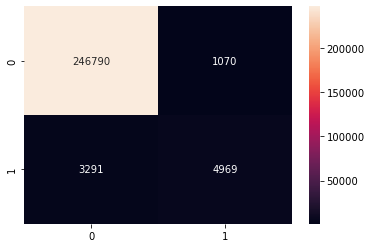

In [27]:
print("Logistic regression monovariable")
get_metrics(X_train_0, Y_train_0, X_test_0, Y_test_0, logistic_0)

Logistic regression on all variables
    f1-score on train set :  0.7625754527162979
    f1-score on test set :  0.7711711711711712

    precision_score on train set :  0.8548872180451128
    precision_score on test set :  0.8594377510040161

    recall_score on train set :  0.6882566585956417
    recall_score on test set :  0.6993464052287581

    Confusion matrix on train set : 



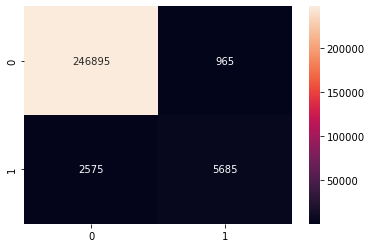

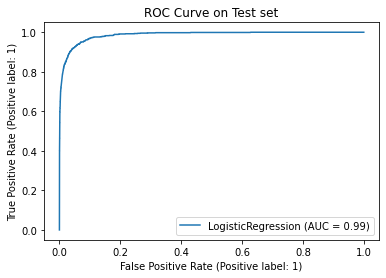

In [67]:
print("Logistic regression on all variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, logistic_1)

# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set")
RocCurveDisplay.from_estimator(logistic_1, X_test_1, Y_test_1, ax=ax) # RocCurveDisplay from sklearn
plt.show()

It seems like recall was improved as exprected but precision was lowered... Crossval would be necessary...

Logistic regression with threshold on all variables
    f1-score on train set :  0.7704615384615384
    f1-score on test set :  0.7649006622516555

    precision_score on train set :  0.7834793491864831
    precision_score on test set :  0.7751677852348994

    recall_score on train set :  0.7578692493946732
    recall_score on test set :  0.7549019607843137

    Confusion matrix on train set : 



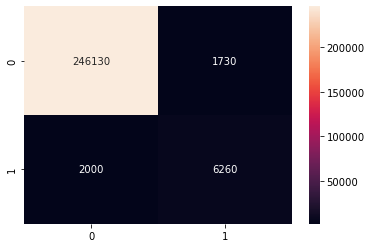

In [79]:
print("Logistic regression with threshold on all variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, logistic_threshold_1)

Logistic regression on feature-engineered variables
    f1-score on train set :  0.7616941428762901
    f1-score on test set :  0.7686746987951807

    precision_score on train set :  0.8530471329930952
    precision_score on test set :  0.8598382749326146

    recall_score on train set :  0.6880145278450364
    recall_score on test set :  0.6949891067538126

    Confusion matrix on train set : 



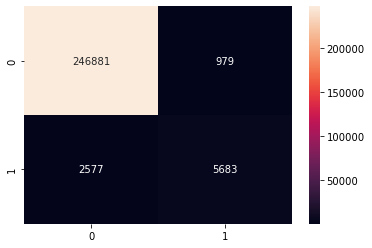

In [30]:
print("Logistic regression on feature-engineered variables")
get_metrics(X_train_2, Y_train_2, X_test_2, Y_test_2, logistic_2)

One tree, raw variables
    f1-score on train set :  0.7968230262711289
    f1-score on test set :  0.7287201469687691

    precision_score on train set :  0.9069695564827692
    precision_score on test set :  0.8321678321678322

    recall_score on train set :  0.7105326876513317
    recall_score on test set :  0.6481481481481481

    Confusion matrix on train set : 



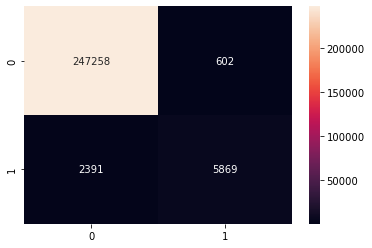

In [31]:
print("One tree, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, tree_1)

Random forest, raw variables
    f1-score on train set :  0.8018012052181976
    f1-score on test set :  0.7449584816132858

    precision_score on train set :  0.8849583394240608
    precision_score on test set :  0.8177083333333334

    recall_score on train set :  0.7329297820823245
    recall_score on test set :  0.6840958605664488

    Confusion matrix on train set : 



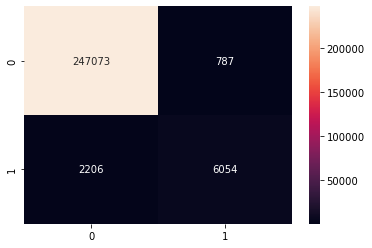

In [32]:
print("Random forest, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, forest_1)

AdaBoost, raw variables
    f1-score on train set :  0.7532834916144676
    f1-score on test set :  0.7528700906344411

    precision_score on train set :  0.8489448914528617
    precision_score on test set :  0.8453188602442334

    recall_score on train set :  0.676997578692494
    recall_score on test set :  0.6786492374727668

    Confusion matrix on train set : 



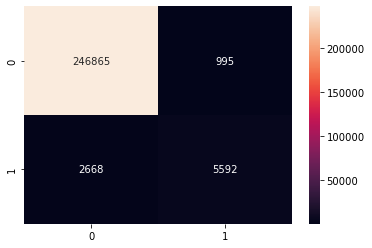

In [33]:
print("AdaBoost, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, adaboost_1)

XGBoost, raw variables
    f1-score on train set :  0.7734968670843888
    f1-score on test set :  0.7539015606242498

    precision_score on train set :  0.8605754968851973
    precision_score on test set :  0.839572192513369

    recall_score on train set :  0.7024213075060532
    recall_score on test set :  0.6840958605664488

    Confusion matrix on train set : 



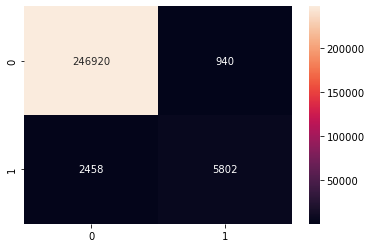

In [34]:
print("XGBoost, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, xgb_1)

Gridsearched forest, raw variables
    f1-score on train set :  0.7672888411440849
    f1-score on test set :  0.7563329312424607

    precision_score on train set :  0.861320470304492
    precision_score on test set :  0.8472972972972973

    recall_score on train set :  0.6917675544794188
    recall_score on test set :  0.6830065359477124

    Confusion matrix on train set : 



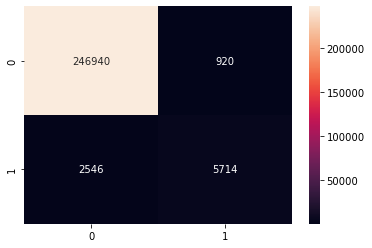

In [35]:
print("Gridsearched forest, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, gridsearch_forest)

Voting, raw variables
    f1-score on train set :  0.7846627408993577
    f1-score on test set :  0.7534659433393611

    precision_score on train set :  0.8771693596648713
    precision_score on test set :  0.8434547908232118

    recall_score on train set :  0.7098062953995158
    recall_score on test set :  0.6808278867102396

    Confusion matrix on train set : 



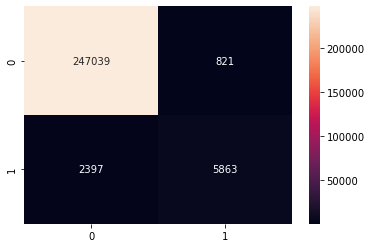

In [43]:
print("Voting, raw variables")
get_metrics(X_train_1, Y_train_1, X_test_1, Y_test_1, vote_1)

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
def create_prediction(features_list, X_train, X_test, Y_train, Y_test, preprocessor, classifier, classifier_name):
    # Concatenate our train and test set to train the classifier on all data with labels
    X = np.append(X_train, X_test, axis=0)
    Y = np.append(Y_train, Y_test)
    classifier.fit(X,Y)
    
    # Read data without labels
    data_without_labels = pd.read_csv('conversion_data_test.csv')
    print('Prediction set (without labels) :', data_without_labels.shape)

    # Warning : check consistency of features_list (must be the same than the features 
    # used by the classifier)
    X_without_labels = data_without_labels.loc[:, features_list]

    # Convert pandas DataFrames to numpy arrays before using scikit-learn
    print("Convert pandas DataFrames to numpy arrays...")
    X_without_labels = X_without_labels.values
    print("...Done")
    print(X_without_labels[0:5,:])
    X_without_labels = preprocessor.transform(X_without_labels)
    
    # Make predictions and dump to file
    # WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
    # WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
    # where [name] is the name of your team/model separated by a '-'
    # For example : [name] = AURELIE-model1
    data = {
        'converted': classifier.predict(X_without_labels)
    }

    Y_predictions = pd.DataFrame(columns=['converted'],data=data)
    Y_predictions.to_csv(f"conversion_data_test_predictions_{classifier_name}-quentin.csv", index=False)
    


Baseline model for first submission, to make sure our pipeline is ok.

In [ ]:
# Baseline model prediction, used to test submission pipeline early
create_prediction(features_list_0, X_train_0, X_test_0, Y_train_0, Y_test_0, preprocessor_0, logistic_0, "v0")

Best model predictions

In [ ]:
# Best model prediction, for final submission
create_prediction(features_list_1, X_train_1, X_test_1, Y_train_1, Y_test_1, preprocessor_1, logistic_1, "v1")

## Analyzing the coefficients and interpreting the result
Let's compare the coefficients for logistic regressions between models using age or age_log

In [61]:
# Prints the coefficients given to each feature by a model
def print_coef(name, coef):
    coef_names = ["country_0", "country_1", "country_1", "age      ", "new_user ", "source_0 ", "source_1 ", "tot_pg_vs"]
    print(f"{name} coefficients:")
    for i in range(len(coef[0])):
        print(f"    {coef_names[i]}: {coef[0][i]}")

In [65]:
print_coef("Logisitic regression", logistic_1.coef_)
print_coef("\nLogisitic r with age_log", logistic_2.coef_)

Logisitic regression coefficients:
    country_0: -0.6165124636125281
    country_1: 2.5397762458750925
    country_1: 3.614090971456287
    age      : 3.4178952874545168
    new_user : 3.088186849336254
    source_0 : -1.7146064612158753
    source_1 : -0.24033968308929188
    tot_pg_vs: -0.05323535083584343

Logisitic r with age_log coefficients:
    country_0: -0.5699951009860461
    country_1: 2.540883737824318
    country_1: 3.6181775443699338
    age      : 3.4223400573858185
    new_user : 3.0917107282279757
    source_0 : -1.7160957480170982
    source_1 : -0.24118867797091761
    tot_pg_vs: -0.05462290137058657


We don't see a big difference depending on the features choice. Nevertheless doing more feature engineering is probably the key to improve performance here. Since most of the algorithms we tried gave similar performance, further investigations on the data itself would be needed to understand customers behaviour.